In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import cPickle as pickle
import codecs

from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster.bicluster import SpectralCoclustering
from biclustering.biclustering import DeltaBiclustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

In [17]:
%matplotlib inline
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

In [18]:
def generate_dataset(option, noise=1, noise_background=True, shuffle=False):
    shape = (150,150)
    n,m = shape
    
    # values can't be a lot far...
    centers = [20, 40, 60, 80, 100]
    
    y_row = np.zeros(150)
    y_col = np.zeros(150)

    if noise_background:
        data = np.random.rand(n, m)*100
    else:
        data = np.zeros(n*m).reshape(shape)

    if option == 'a':
        data[60:110][:,70:140] = np.random.rand(50,70)*noise + centers[0]
        y_row[60:110] += 1
        y_col[70:140] += 1
    elif option == 'd':
        data[0:50][:,0:70] = np.random.rand(50,70)*noise + centers[0]
        y_row[0:50] += 1
        y_col[0:70] += 1

        data[50:100][:,50:100] = np.random.rand(50,50)*noise + centers[2]
        y_row[50:100] += 2
        y_col[50:100] += 2

        data[100:150][:,80:150] = np.random.rand(50,70)*noise + centers[1]
        y_row[100:150] += 3
        y_col[80:150] += 3
    elif option == 'e':
        data[0:70][:,0:50] = np.random.rand(70,50)*noise + centers[3]
        y_row[0:70] += 1
        y_col[0:50] += 1

        data[50:100][:,50:100] = np.random.rand(50,50)*noise + centers[1]
        y_row[50:100] += 2
        y_col[50:100] += 2

        data[80:150][:,100:150] = np.random.rand(70,50)*noise + centers[2]
        y_row[80:150] += 3
        y_col[100:150] += 3
    elif option == 'f':
        data[0:50][:,0:40] = np.random.rand(50,40)*noise + centers[4]
        y_row[0:50] += 1
        y_col[0:40] += 1

        data[50:150][:,0:40] = np.random.rand(100,40)*noise + centers[0]
        y_row[50:150] += 2

        data[110:150][:,40:95] = np.random.rand(40,55)*noise + centers[2]
        y_row[110:150] += 3
        y_col[40:95] += 2

        data[110:150][:,95:150] = np.random.rand(40,55)*noise + centers[1]
        y_row[110:150] += 3
        y_col[95:150] += 3
    elif option == 'g':
        data[0:110][:,0:40] = np.random.rand(110,40)*noise + centers[0]
        data[110:150][:,0:110] = np.random.rand(40,110)*noise + centers[2]
        data[40:150][:,110:150] = np.random.rand(110,40)*noise + centers[1]
        data[0:40][:,40:150] = np.random.rand(40,110)*noise + centers[3]
    elif option == 'h':
        data[0:90][:,0:90] = np.random.rand(90,90)*noise + centers[0]
        data[35:55][:,35:55] = (np.random.rand(20,20)*noise + centers[1]) + data[35:55][:,35:55]
        data[110:140][:,35:90] = np.random.rand(30,55)*noise + centers[4]
        data[0:140][:,110:150] = np.random.rand(140,40)*noise + centers[2]
        data[0:55][:,130:150] = (np.random.rand(55,20)*noise + centers[3]) + data[0:55][:,130:150]
    elif option == 'i':
        data[20:70][:,20:70] = np.random.rand(50,50)*noise + centers[0]
        data[20:70][:,100:150] = np.random.rand(50,50)*noise + centers[1]
        data[50:110][:,50:120] = np.random.rand(60,70)*noise + centers[2]
        data[120:150][:,20:100] = np.random.rand(30,80)*noise + centers[3]

    if shuffle:
        np.random.shuffle(data)
        np.random.shuffle(data.T)

    return data, y_row, y_col

In [49]:
def matrix_factorization_overlapping_bin(X, k, l, num_iters=50):
    def weights_initialization(X, n, m, k):
        shuffle_inds = np.random.permutation(n)
        cluster_end_ind = 0
        for i in xrange(k):
            cluster_init_ind = cluster_end_ind
            cluster_end_ind = round((i + 1) * n / k)
            X[shuffle_inds[cluster_init_ind : cluster_end_ind], i] = 1
        return X

    def calculate_block_matrix(X, F, G, S, k, l):
        for i in xrange(k):
            for j in xrange(l):
                S[i, j] = np.mean(X[F[:, i] == 1][:, G[i][:, j] == 1])
        where_are_NaNs = np.isnan(S)
        S[where_are_NaNs] = 0
        return S

    n, m = X.shape

    error_best = np.inf

    F = weights_initialization(np.zeros((n, k)), n, m, k)

    G = []
    for i in xrange(k):
        G.append( weights_initialization(np.zeros((m, l)), m, n, l) )

    S = np.random.rand(k, l)

    for iter_ind in xrange(num_iters):
        S = calculate_block_matrix(X, F, G, S, k, l)

        # Update G
        for i in xrange(k):
            F_t = F[F[:, i] == 1, :].dot(S)
            X_t = X[F[:, i] == 1, :]
            G[i] = np.zeros((m, l))
            for j in xrange(m):
                clust_len, _ = X_t.shape
                diff = F_t - X_t[:, j].reshape(clust_len, 1).dot(np.ones(l).reshape(1, l))
                errors = np.diag(diff.T.dot(diff))
                minV = np.min(errors)
                index = np.where(errors <= minV)[0]
                G[i][j, index[np.random.randint(len(index))]] = 1

            while np.linalg.det(G[i].T.dot(G[i])) <= 0:
                erros = (X_t - F_t.dot(G[i].T)) ** 2
                erros = np.sum(erros.dot(G[i]), axis=1) / np.sum(G[i], axis=0)
                erros[np.where(np.sum(G[i], axis=0) <= 1)] = -np.inf
                quantidade = np.sum(G[i], axis=0)
                indexMin = np.argmin(quantidade)
                indexMax = np.argmax(erros)
                indexes = np.nonzero(G[i][:, indexMax])[0]

                for j in indexes:
                    if np.random.rand(1) > 0.5:
                        G[i][j, indexMax] = 0.0
                        G[i][j, indexMin] = 1.0

#         S = calculate_block_matrix(X, F, G, S, k, l)

        G_t = np.zeros((k, m))
        for i in xrange(k):
            G_t[i, :] = S[i, :].dot(G[i].T)

        F = np.zeros((n, k))
        for j in xrange(n):
            diff = G_t - np.ones(k).reshape(k, 1).dot(X[j, :].reshape(1, m))
            errors = np.diag(diff.dot(diff.T))
            minV = np.min(errors)
            index = np.where(errors <= minV)[0]
            F[j, index[np.random.randint(len(index))]] = 1

        while np.linalg.det(F.T.dot(F)) <= 0:
            erros = (X - F.dot(G_t)) ** 2
            erros = np.sum(F.T.dot(erros), axis=1) / np.sum(F, axis=0)
            erros[np.where(np.sum(F, axis=0) <= 1)] = -np.inf
            quantidade = np.sum(F, axis=0)
            indexMin = np.argmin(quantidade)
            indexMax = np.argmax(erros)
            indexes = np.nonzero(F[:, indexMax])[0]

            end = len(indexes)
            indexes_p = np.random.permutation(end)
            F[indexes[indexes_p[0:np.floor(end/2.0)]], indexMax] = 0.0
            F[indexes[indexes_p[0:np.floor(end/2.0)]], indexMin] = 1.0

        error = np.sum((X - F.dot(G_t))**2)
        print error

        if error < error_best:
            error = error_best
            F_best = F
            S_best = S
            G_best = G
            G_t_best = G_t

    rows_ind = np.argmax(F_best, axis=1)

    return F, S, G, G_t, rows_ind, error_best

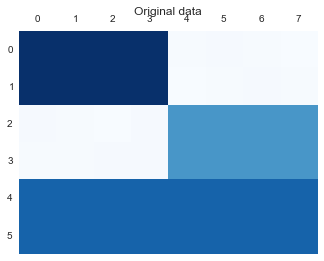

In [50]:
n, m = (6, 8)
X = .01 * np.random.rand(n, m)
X[0:2][:, 0:4] = 1 + .01 * np.random.random()
X[2:4][:, 4:8] = .6 + .01 * np.random.random()
X[4:6][:, 0:8] = .8 + .01 * np.random.random()

plt.matshow(X, cmap=plt.cm.Blues)
plt.title('Original data')
plt.grid()
plt.show()

In [51]:
F, S, G, G_t, rows_ind, error = matrix_factorization_overlapping_bin(X, 3, 2, num_iters=100)

2.43299886315
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896656
0.000133362896

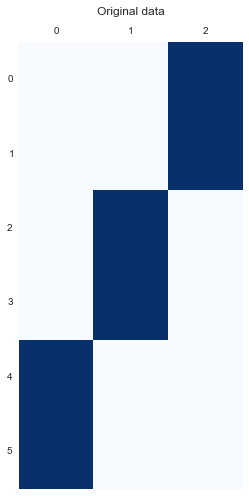

In [52]:
plt.matshow(F, cmap=plt.cm.Blues)
plt.title('Original data')
plt.grid()
plt.show()

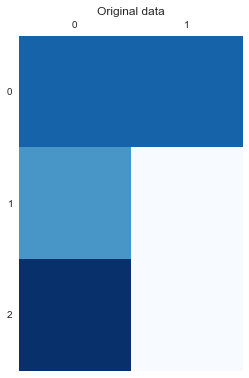

In [53]:
plt.matshow(S, cmap=plt.cm.Blues)
plt.title('Original data')
plt.grid()
plt.show()

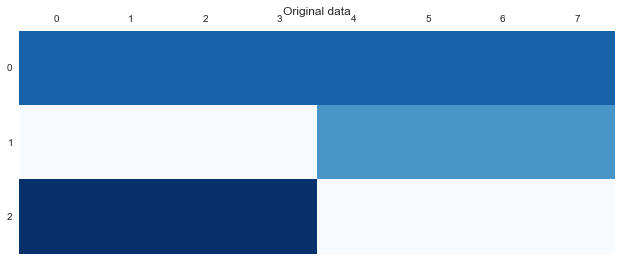

In [54]:
plt.matshow(G_t, cmap=plt.cm.Blues)
plt.title('Original data')
plt.grid()
plt.show()